In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

`tensorflow-dataset`에서 제공하는 [cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)을 이용해서 object detection을 수행한다

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

`tfds.show_examples`을 통해 데이터셋을 살펴보자.

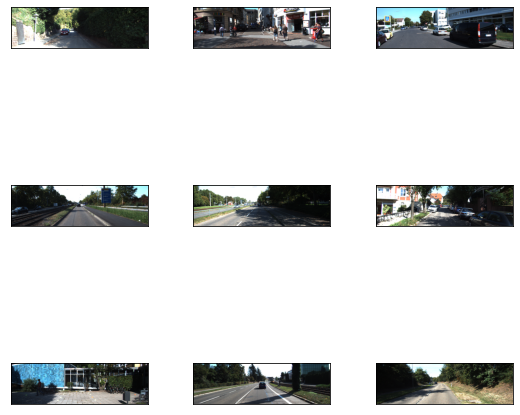

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

데이터셋은 6,347개의 학습 데이터(training data),  
711개의 평가용 데이터(test data),   
423개의 검증용 데이터(validation data)로 구성되어 있으며,   
라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있다.

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

`ds_train.take(1)` 을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-1.75, -2.91, -2.59, -2.99,  2.36,  1.57, -3.03, -3.  , -1.28,
        1.68,  1.76,  1.68], dtype=float32)>, 'bbox': <tf.Tensor: shape=(12, 4), dtype=float32, numpy=
array([[0.37173796, 0.47125202, 0.51580215, 0.48740712],
       [0.37671122, 0.48536348, 0.5254813 , 0.50235057],
       [0.03909091, 0.20465267, 0.54058826, 0.26950726],
       [0.27122995, 0.246042  , 0.5158556 , 0.2763005 ],
       [0.0026738 , 0.        , 0.6669786 , 0.2585945 ],
       [0.25360963, 0.22241518, 0.52243316, 0.264895  ],
       [0.20457219, 0.6309451 , 0.56018716, 0.6750646 ],
       [0.11088235, 0.82081586, 0.57687163, 0.89568657],
       [0.32911766, 0.26911148, 0.5066578 , 0.29285946],
       [0.3818449 , 0.40418416, 0.5203476 , 0.41716477],
       [0.31799465, 0.29101777, 0.5528342 , 0.3801777 ],
       [0.37406418, 0.34692246, 0.5428877 , 0.39998385]], dtype

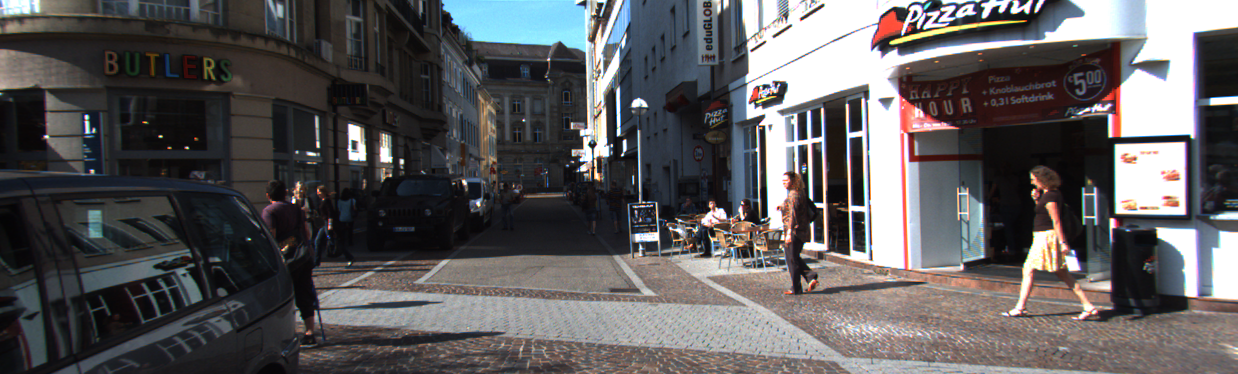

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

바운딩 박스를 그려서 시각화해보자.

width: 1238  height: 374
(12, 4)
[583.41003 234.97    603.41003 181.09   ]
[600.88    233.11    621.91003 177.47   ]
[253.36    359.38    333.65    171.81999]
[304.6  272.56 342.06 181.07]
[  0.   373.   320.14 124.55]
[275.35 279.15 327.94 178.61]
[781.11005 297.49    835.73    164.49   ]
[1016.17004  332.53    1108.86     158.25002]
[333.16    250.91    362.56003 184.51   ]
[500.38 231.19 516.45 179.39]
[360.28 255.07 470.66 167.24]
[429.49    234.09999 495.18002 170.96   ]
<PIL.Image.Image image mode=RGB size=1238x374 at 0x7F926010BED0>


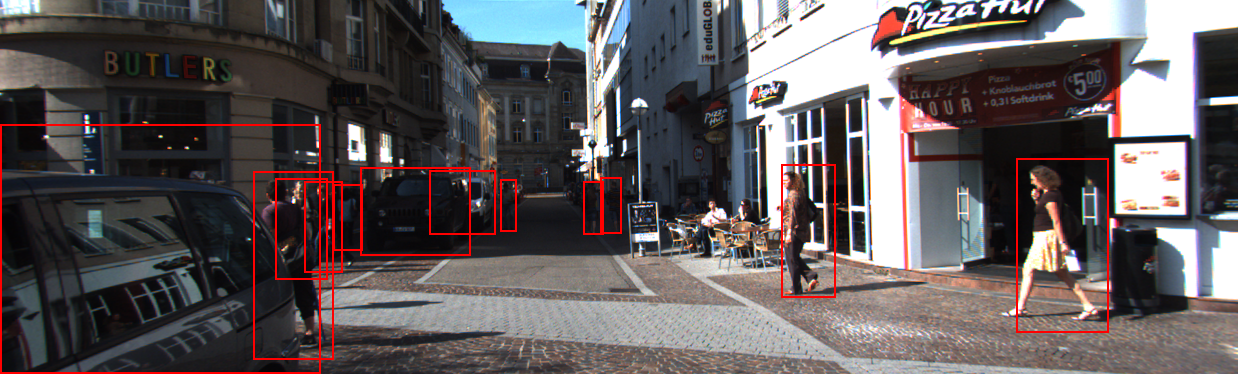

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

     # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## RetinaNet
RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델이다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었다.   
이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용한다.

- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
- [김홍배님의 Focal loss의 응용(Detection & Classification)](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)

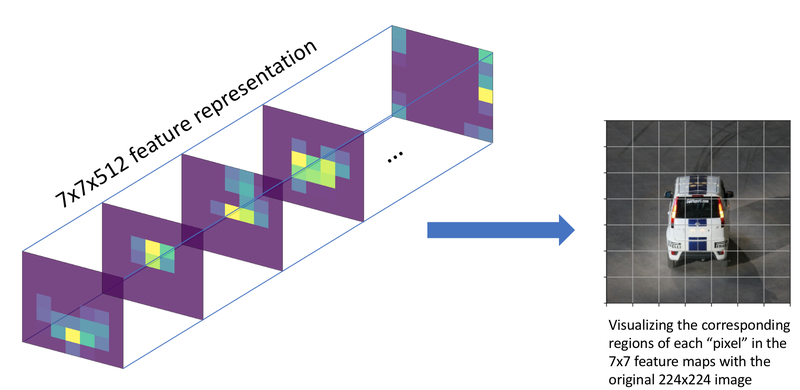
출처: [https://www.jeremyjordan.me/object-detection-one-stage/](https://www.jeremyjordan.me/object-detection-one-stage/)

### Focal Loss
Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었다.

### FPN(Feature Pyramid Network)
FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식이며, CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있다.

[Keras RetineNet](https://github.com/fizyr/keras-retinanet)  
Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet이다.

나중에 데이터포멧 저장시에는 확장자는 `.csv`로 형식은 아래와 같이 저장해주자.
```
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,
```
CSV로 저장할 때는 아래 코드를 참고

```
# 데이터셋 저장 시 참고
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('원하는 폴더', sep=',', index=False, header=False)
```

`tqdm`은 루프문의 상태에 따라 콘솔에 진행 상황 바를 표시할 수 있는 라이브러리이다.  
[GitHub: tqdm](https://github.com/tqdm/tqdm)

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
    
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [23:59<00:00,  4.41it/s]


테스트 데이터셋에 대해서도 동일하게 `parse_dataset()` 을 적용하자.

In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:42<00:00,  4.39it/s]


### 클래스 맵핑
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 한다.  
이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있다.
```
class_name,id

#Example
cow,0
cat,1
bird,2

```

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')


save_class_format(class_txt_path)

Done


## 셋팅

In [10]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 

!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-08 03:13:49.922862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 03:13:52.089507: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-08 03:13:52.093751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-08 03:13:52.102683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-08 03:13:52.102734: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 03:13:52.106257: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-08

2021-10-08 03:14:02.675617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-08 03:14:02.676119: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2596990000 Hz
Epoch 1/10
2021-10-08 03:14:12.632519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-10-08 03:14:13.811261: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-10-08 03:14:13.857459: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-08 03:14:14.543709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-08 03:14:14.770168: I tensor

In [11]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-08 03:52:29.040670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 03:52:30.760480: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-08 03:52:30.761530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-08 03:52:30.770229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-08 03:52:30.770275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 03:52:30.774405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-08

## 시각화

In [12]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.37    174.42134 626.00385 207.1732 ]
[192.3417  132.18597 347.06403 230.49327]
[370.42688 182.60237 421.80185 211.37138]
[531.0809  160.02736 563.5376  190.57521]


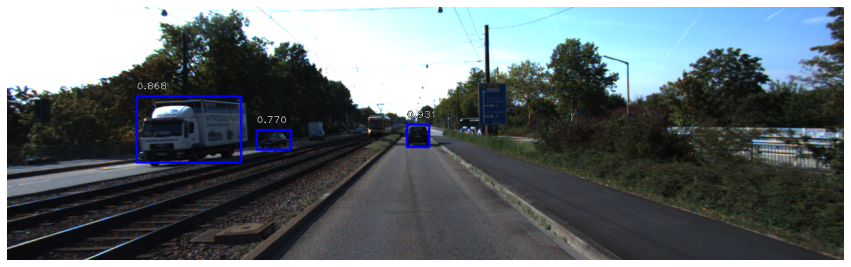

In [13]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

     # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            


inference_on_image(model, img_path)

[772.0739  134.1291  844.6209  320.16116]
[797.06366 144.3483  863.7656  316.525  ]


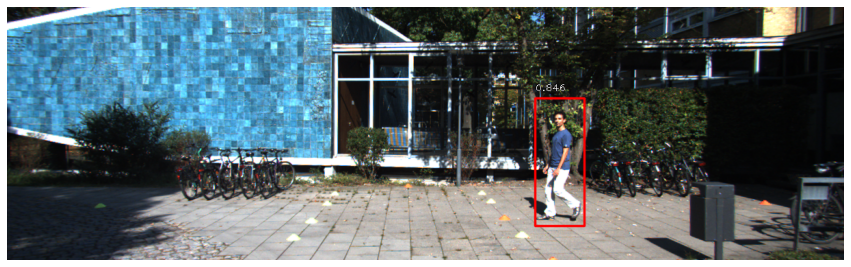

In [14]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)